# GMM Study with Pooled Embeddings

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import optuna
from optuna.samplers import TPESampler
from pathlib import Path
import os

sns.set_style("whitegrid")
print("All imports successful")

All imports successful


## Load Pooled Embeddings

In [3]:
# Load train embeddings
train_path = "./pooled_embeddings/train_embeddings.npz"
train_data = np.load(train_path)
X_train = train_data['embeddings']
y_train = train_data['labels']

print(f"Train embeddings loaded:")
print(f"  Shape: {X_train.shape}")
print(f"  Labels shape: {y_train.shape}")

# Load test embeddings
test_path = "./pooled_embeddings/test_embeddings.npz"
test_data = np.load(test_path)
X_test = test_data['embeddings']
y_test = test_data['labels']

print(f"\nTest embeddings loaded:")
print(f"  Shape: {X_test.shape}")
print(f"  Labels shape: {y_test.shape}")

# Convert labels to binary (0='good', 1='anomalous')
true_labels = np.array([0 if str(label).lower() == 'good' else 1 for label in y_test])
print(f"\nTest set composition:")
print(f"  Good samples: {(true_labels == 0).sum()}")
print(f"  Anomalous samples: {(true_labels == 1).sum()}")

Train embeddings loaded:
  Shape: (3629, 384)
  Labels shape: (3629,)

Test embeddings loaded:
  Shape: (1725, 384)
  Labels shape: (1725,)

Test set composition:
  Good samples: 467
  Anomalous samples: 1258


## Fit GMM to Train Embeddings

In [4]:
K = 15

print(f"Fitting GMM with K={K} components...")
gmm_model = GaussianMixture(n_components=K, covariance_type='full')
gmm_model.fit(X_train)

print(f"✓ GMM fitted with K={K} components on {len(X_train)} samples with {X_train.shape[1]} features")

Fitting GMM with K=15 components...
✓ GMM fitted with K=15 components on 3629 samples with 384 features


## Calculate Log-Likelihood Scores for Test Set

In [5]:
# Get log-likelihood scores for test set
ll_scores = gmm_model.score_samples(X_test)

print(f"Log-Likelihood scores computed:")
print(f"  Min: {ll_scores.min():.4f}")
print(f"  Max: {ll_scores.max():.4f}")
print(f"  Mean: {ll_scores.mean():.4f}")
print(f"  Std: {ll_scores.std():.4f}")

Log-Likelihood scores computed:
  Min: -392895.1250
  Max: 55.5204
  Mean: -64969.7109
  Std: 80189.8672


## Setup Cross-Validation (K-Fold)

In [6]:
# Initialize K-Fold with stratification on test set
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for cross-validation
cv_folds = []
for fold_idx, (tune_indices, test_indices) in enumerate(kfold.split(X_test, true_labels)):
    cv_folds.append({
        'fold': fold_idx + 1,
        'tune_indices': tune_indices,
        'test_indices': test_indices
    })

print(f"Created {len(cv_folds)} K-Fold splits")
for fold_info in cv_folds:
    tune_size = len(fold_info['tune_indices'])
    test_size = len(fold_info['test_indices'])
    print(f"  Fold {fold_info['fold']}: tune_set={tune_size} samples, test_set={test_size} samples")

Created 5 K-Fold splits
  Fold 1: tune_set=1380 samples, test_set=345 samples
  Fold 2: tune_set=1380 samples, test_set=345 samples
  Fold 3: tune_set=1380 samples, test_set=345 samples
  Fold 4: tune_set=1380 samples, test_set=345 samples
  Fold 5: tune_set=1380 samples, test_set=345 samples


## Combine Validation Data Across All Folds

In [7]:
# Concatenate all tune_set samples and labels across 5 folds
tune_indices_combined = np.concatenate([f['tune_indices'] for f in cv_folds])

X_tune_combined = X_test[tune_indices_combined]
y_tune_combined = true_labels[tune_indices_combined]
ll_tune_combined = gmm_model.score_samples(X_tune_combined)

print(f"Combined validation set (across all folds):")
print(f"  Total samples: {X_tune_combined.shape[0]}")
print(f"  Good samples: {(y_tune_combined == 0).sum()}")
print(f"  Anomalous samples: {(y_tune_combined == 1).sum()}")
print(f"  LL score range: [{ll_tune_combined.min():.4f}, {ll_tune_combined.max():.4f}]")
print(f"  LL score mean: {ll_tune_combined.mean():.4f}")
print(f"  LL score std: {ll_tune_combined.std():.4f}")

Combined validation set (across all folds):
  Total samples: 6900
  Good samples: 1868
  Anomalous samples: 5032
  LL score range: [-392895.1562, 55.5209]
  LL score mean: -64969.7109
  LL score std: 80189.8672


## Optuna Optimization on Combined Validation Data

In [8]:
print("\n" + "="*70)
print("CROSS-VALIDATION THRESHOLD TUNING (K-Fold, K=5)")
print("="*70)
print(f"Optimizing: F1 Score")
print(f"Search range: [{ll_tune_combined.min():.4f}, {ll_tune_combined.max():.4f}]")
print(f"Validation samples: {len(X_tune_combined)}")
print(f"Optuna trials: 100")
print("="*70)

def cv_objective(trial):
    """
    Objective function for Optuna - maximize F1 score on combined validation set.
    """
    threshold = trial.suggest_float("threshold", ll_tune_combined.min(), ll_tune_combined.max())
    
    # Classify based on threshold
    # LL > threshold → GOOD (0), LL ≤ threshold → ANOMALOUS (1)
    predictions = np.where(ll_tune_combined > threshold, 0, 1)
    
    # Calculate F1 score
    f1 = f1_score(y_tune_combined, predictions, zero_division=0)
    
    return f1

# Create study and optimize
sampler = TPESampler(seed=42)
study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(cv_objective, n_trials=100, show_progress_bar=True)

# Get best results
best_threshold = study.best_params["threshold"]
best_f1_validation = study.best_value

print("\n" + "="*70)
print("Optimization Complete")
print("="*70)
print(f"Best threshold found: {best_threshold:.6f}")
print(f"Best F1 on validation set: {best_f1_validation*100:.2f}%")
print("="*70)

[I 2025-12-05 12:49:51,964] A new study created in memory with name: no-name-a74bc4f8-82c2-41ad-a00a-ac02d964c930



CROSS-VALIDATION THRESHOLD TUNING (K-Fold, K=5)
Optimizing: F1 Score
Search range: [-392895.1562, 55.5209]
Validation samples: 6900
Optuna trials: 100


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-05 12:49:51,979] Trial 0 finished with value: 0.14591009579955785 and parameters: {'threshold': -245719.36293024415}. Best is trial 0 with value: 0.14591009579955785.
[I 2025-12-05 12:49:51,984] Trial 1 finished with value: 0.7507692307692307 and parameters: {'threshold': -19311.325772967015}. Best is trial 1 with value: 0.7507692307692307.
[I 2025-12-05 12:49:51,991] Trial 2 finished with value: 0.4665856622114216 and parameters: {'threshold': -105257.64114777133}. Best is trial 1 with value: 0.7507692307692307.
[I 2025-12-05 12:49:51,996] Trial 3 finished with value: 0.32378414390406396 and parameters: {'threshold': -157651.89950503077}. Best is trial 1 with value: 0.7507692307692307.
[I 2025-12-05 12:49:52,000] Trial 4 finished with value: 0.01263823064770932 and parameters: {'threshold': -331587.52584060404}. Best is trial 1 with value: 0.7507692307692307.
[I 2025-12-05 12:49:52,004] Trial 5 finished with value: 0.01263823064770932 and parameters: {'threshold': -331597.0

## Evaluate Best Threshold on Each Fold's Test Set

In [9]:
print("\n" + "="*70)
print("EVALUATING ON HELD-OUT TEST FOLDS")
print("="*70)

fold_results = []

for fold_info in cv_folds:
    fold_idx = fold_info['fold']
    test_indices = fold_info['test_indices']
    
    # Extract test fold data
    X_test_fold = X_test[test_indices]
    y_test_fold = true_labels[test_indices]
    ll_test_fold = gmm_model.score_samples(X_test_fold)
    
    # Apply best threshold found during optimization
    # LL > threshold → GOOD (0), LL ≤ threshold → ANOMALOUS (1)
    predictions_fold = np.where(ll_test_fold > best_threshold, 0, 1)
    
    # Calculate metrics
    f1 = f1_score(y_test_fold, predictions_fold, zero_division=0)
    precision = precision_score(y_test_fold, predictions_fold, zero_division=0)
    recall = recall_score(y_test_fold, predictions_fold, zero_division=0)
    accuracy = accuracy_score(y_test_fold, predictions_fold)
    
    fold_results.append({
        'Fold': fold_idx,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'N_Good': (y_test_fold == 0).sum(),
        'N_Anomalous': (y_test_fold == 1).sum(),
        'N_Total': len(test_indices)
    })
    
    print(f"\nFold {fold_idx}:")
    print(f"  Test set size: {len(test_indices)} (Good: {(y_test_fold == 0).sum()}, Anomalous: {(y_test_fold == 1).sum()})")
    print(f"  F1:        {f1*100:.2f}%")
    print(f"  Precision: {precision*100:.2f}%")
    print(f"  Recall:    {recall*100:.2f}%")
    print(f"  Accuracy:  {accuracy*100:.2f}%")

# Create results DataFrame
results_df = pd.DataFrame(fold_results)


EVALUATING ON HELD-OUT TEST FOLDS

Fold 1:
  Test set size: 345 (Good: 93, Anomalous: 252)
  F1:        85.52%
  Precision: 74.93%
  Recall:    99.60%
  Accuracy:  75.36%

Fold 2:
  Test set size: 345 (Good: 93, Anomalous: 252)
  F1:        84.55%
  Precision: 73.89%
  Recall:    98.81%
  Accuracy:  73.62%

Fold 3:
  Test set size: 345 (Good: 93, Anomalous: 252)
  F1:        86.45%
  Precision: 76.13%
  Recall:    100.00%
  Accuracy:  77.10%

Fold 4:
  Test set size: 345 (Good: 94, Anomalous: 251)
  F1:        84.89%
  Precision: 73.96%
  Recall:    99.60%
  Accuracy:  74.20%

Fold 5:
  Test set size: 345 (Good: 94, Anomalous: 251)
  F1:        85.91%
  Precision: 75.53%
  Recall:    99.60%
  Accuracy:  76.23%


## Final Results Summary

In [10]:
# Calculate summary statistics
mean_f1 = results_df['F1'].mean()
std_f1 = results_df['F1'].std()
mean_precision = results_df['Precision'].mean()
std_precision = results_df['Precision'].std()
mean_recall = results_df['Recall'].mean()
std_recall = results_df['Recall'].std()
mean_accuracy = results_df['Accuracy'].mean()
std_accuracy = results_df['Accuracy'].std()

print("\n" + "="*70)
print("CROSS-VALIDATION RESULTS SUMMARY")
print("="*70)
print(f"\nBest Threshold (from optimization): {best_threshold:.6f}")
print(f"Validation F1 (during optimization): {best_f1_validation*100:.2f}%")
print(f"\nAggregated Test Performance (across 5 folds):")
print(f"  F1:        {mean_f1*100:.2f}% ± {std_f1*100:.2f}%")
print(f"  Precision: {mean_precision*100:.2f}% ± {std_precision*100:.2f}%")
print(f"  Recall:    {mean_recall*100:.2f}% ± {std_recall*100:.2f}%")
print(f"  Accuracy:  {mean_accuracy*100:.2f}% ± {std_accuracy*100:.2f}%")
print(f"\nPer-Fold Breakdown:")
print(results_df.to_string(index=False))
print("="*70)


CROSS-VALIDATION RESULTS SUMMARY

Best Threshold (from optimization): -2133.610551
Validation F1 (during optimization): 85.46%

Aggregated Test Performance (across 5 folds):
  F1:        85.46% ± 0.76%
  Precision: 74.89% ± 0.98%
  Recall:    99.52% ± 0.43%
  Accuracy:  75.30% ± 1.43%

Per-Fold Breakdown:
 Fold       F1  Precision   Recall  Accuracy  N_Good  N_Anomalous  N_Total
    1 0.855196   0.749254 0.996032  0.753623      93          252      345
    2 0.845501   0.738872 0.988095  0.736232      93          252      345
    3 0.864494   0.761329 1.000000  0.771014      93          252      345
    4 0.848896   0.739645 0.996016  0.742029      94          251      345
    5 0.859107   0.755287 0.996016  0.762319      94          251      345


## Visualization of Cross-Validation Results

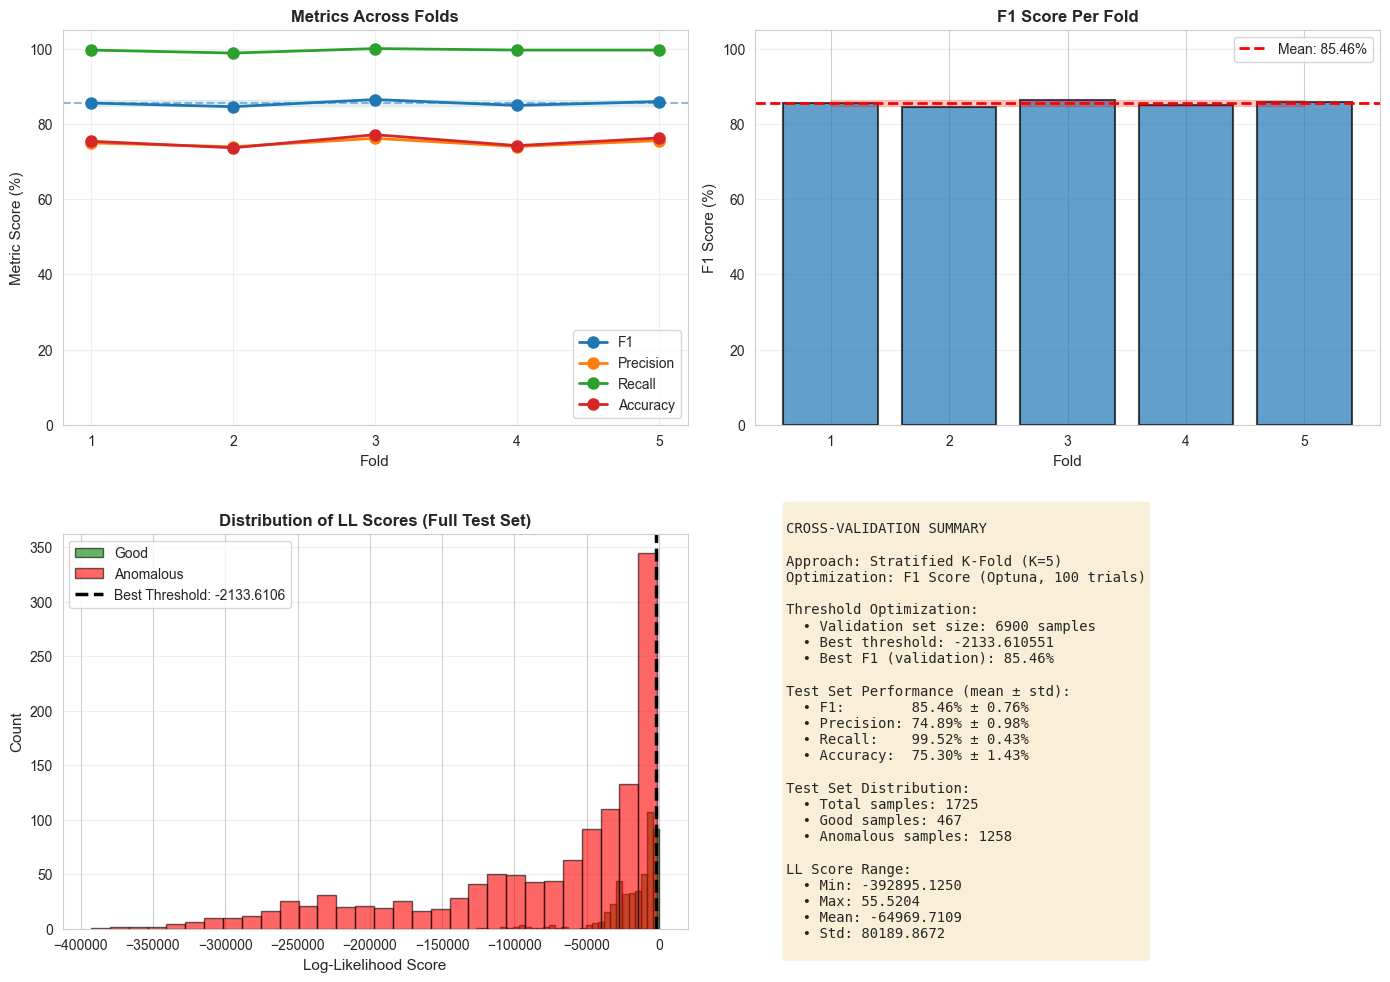

✓ Visualization complete - saved as 'cv_pooled_results.png'


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Metrics across folds (line plot with error bands)
ax = axes[0, 0]
folds = results_df['Fold'].values
metrics_names = ['F1', 'Precision', 'Recall', 'Accuracy']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for metric, color in zip(metrics_names, colors):
    values = results_df[metric].values * 100
    ax.plot(folds, values, marker='o', linewidth=2, markersize=8, label=metric, color=color)

ax.axhline(y=mean_f1*100, color='#1f77b4', linestyle='--', alpha=0.5)
ax.fill_between(folds, (mean_f1 - std_f1)*100, (mean_f1 + std_f1)*100, alpha=0.1, color='#1f77b4')
ax.set_xlabel('Fold', fontsize=11)
ax.set_ylabel('Metric Score (%)', fontsize=11)
ax.set_title('Metrics Across Folds', fontsize=12, fontweight='bold')
ax.set_xticks(folds)
ax.set_ylim([0, 105])
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Plot 2: F1 Score per fold with error bars
ax = axes[0, 1]
f1_values = results_df['F1'].values * 100
folds_list = results_df['Fold'].values
ax.bar(folds_list, f1_values, color='#1f77b4', alpha=0.7, edgecolor='black', linewidth=1.5)
ax.axhline(y=mean_f1*100, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_f1*100:.2f}%')
ax.fill_between(folds_list, mean_f1*100 - std_f1*100, mean_f1*100 + std_f1*100, alpha=0.2, color='red')
ax.set_xlabel('Fold', fontsize=11)
ax.set_ylabel('F1 Score (%)', fontsize=11)
ax.set_title('F1 Score Per Fold', fontsize=12, fontweight='bold')
ax.set_xticks(folds_list)
ax.set_ylim([0, 105])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 3: Log-Likelihood Distribution with best threshold
ax = axes[1, 0]
good_mask = true_labels == 0
anomalous_mask = true_labels == 1
ax.hist(ll_scores[good_mask], bins=30, alpha=0.6, label='Good', color='green', edgecolor='black')
ax.hist(ll_scores[anomalous_mask], bins=30, alpha=0.6, label='Anomalous', color='red', edgecolor='black')
ax.axvline(x=best_threshold, color='black', linestyle='--', linewidth=2.5, label=f'Best Threshold: {best_threshold:.4f}')
ax.set_xlabel('Log-Likelihood Score', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Distribution of LL Scores (Full Test Set)', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Plot 4: Study statistics text box
ax = axes[1, 1]
ax.axis('off')
stats_text = f"""
CROSS-VALIDATION SUMMARY

Approach: Stratified K-Fold (K=5)
Optimization: F1 Score (Optuna, 100 trials)

Threshold Optimization:
  • Validation set size: {len(X_tune_combined)} samples
  • Best threshold: {best_threshold:.6f}
  • Best F1 (validation): {best_f1_validation*100:.2f}%

Test Set Performance (mean ± std):
  • F1:        {mean_f1*100:.2f}% ± {std_f1*100:.2f}%
  • Precision: {mean_precision*100:.2f}% ± {std_precision*100:.2f}%
  • Recall:    {mean_recall*100:.2f}% ± {std_recall*100:.2f}%
  • Accuracy:  {mean_accuracy*100:.2f}% ± {std_accuracy*100:.2f}%

Test Set Distribution:
  • Total samples: {len(true_labels)}
  • Good samples: {(true_labels == 0).sum()}
  • Anomalous samples: {(true_labels == 1).sum()}

LL Score Range:
  • Min: {ll_scores.min():.4f}
  • Max: {ll_scores.max():.4f}
  • Mean: {ll_scores.mean():.4f}
  • Std: {ll_scores.std():.4f}
"""
ax.text(0.05, 0.5, stats_text, fontsize=10, family='monospace',
        verticalalignment='center', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('cv_pooled_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualization complete - saved as 'cv_pooled_results.png'")

In [12]:
print("\n" + "="*70)
print("SANITY CHECK: TRIVIAL CASE - THRESHOLD AT TOP END")
print("="*70)
print("Testing threshold at the top end (all samples classified as anomalies)")
print("="*70)

# Set threshold above the maximum LL score
# This means ALL samples will have LL ≤ threshold → all classified as ANOMALOUS (1)
trivial_threshold = ll_scores.max() + 1.0

print(f"\nThreshold set to: {trivial_threshold:.6f}")
print(f"(max LL score + 1.0 = {ll_scores.max():.6f} + 1.0)")
print(f"\nExpected: All samples classified as ANOMALOUS (1)")

# Classify all test samples with trivial threshold
trivial_predictions = np.where(ll_scores > trivial_threshold, 0, 1)

# Verify all are classified as anomalous
print(f"\nResults on FULL TEST SET:")
print(f"  Good predictions: {(trivial_predictions == 0).sum()} (expected: 0)")
print(f"  Anomalous predictions: {(trivial_predictions == 1).sum()} (expected: {len(true_labels)})")

# Calculate metrics on full test set
trivial_f1 = f1_score(true_labels, trivial_predictions, zero_division=0)
trivial_precision = precision_score(true_labels, trivial_predictions, zero_division=0)
trivial_recall = recall_score(true_labels, trivial_predictions, zero_division=0)
trivial_accuracy = accuracy_score(true_labels, trivial_predictions)

print(f"\nMetrics on full test set (threshold={trivial_threshold:.6f}):")
print(f"  F1:        {trivial_f1*100:.2f}%")
print(f"  Precision: {trivial_precision*100:.2f}%")
print(f"  Recall:    {trivial_recall*100:.2f}%")
print(f"  Accuracy:  {trivial_accuracy*100:.2f}%")

# Analyze per-fold
print(f"\nPer-fold results (threshold={trivial_threshold:.6f}):")
trivial_fold_results = []

for fold_info in cv_folds:
    fold_idx = fold_info['fold']
    test_indices = fold_info['test_indices']
    
    # Extract test fold data
    y_test_fold = true_labels[test_indices]
    ll_test_fold = gmm_model.score_samples(X_test[test_indices])
    
    # Apply trivial threshold (all classified as anomalies)
    predictions_fold = np.where(ll_test_fold > trivial_threshold, 0, 1)
    
    # Calculate metrics
    f1 = f1_score(y_test_fold, predictions_fold, zero_division=0)
    precision = precision_score(y_test_fold, predictions_fold, zero_division=0)
    recall = recall_score(y_test_fold, predictions_fold, zero_division=0)
    accuracy = accuracy_score(y_test_fold, predictions_fold)
    
    trivial_fold_results.append({
        'Fold': fold_idx,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
    })
    
    print(f"\n  Fold {fold_idx}:")
    print(f"    F1:        {f1*100:.2f}%")
    print(f"    Precision: {precision*100:.2f}%")
    print(f"    Recall:    {recall*100:.2f}%")
    print(f"    Accuracy:  {accuracy*100:.2f}%")

trivial_df = pd.DataFrame(trivial_fold_results)
trivial_mean_f1 = trivial_df['F1'].mean()
trivial_mean_precision = trivial_df['Precision'].mean()
trivial_mean_recall = trivial_df['Recall'].mean()
trivial_mean_accuracy = trivial_df['Accuracy'].mean()

print(f"\nMean metrics across folds:")
print(f"  F1:        {trivial_mean_f1*100:.2f}%")
print(f"  Precision: {trivial_mean_precision*100:.2f}%")
print(f"  Recall:    {trivial_mean_recall*100:.2f}%")
print(f"  Accuracy:  {trivial_mean_accuracy*100:.2f}%")

print("\n" + "="*70)
print(f"Comparison with optimized threshold ({best_threshold:.6f}):")
print("="*70)
print("Metric         | Trivial (all anomalies) | Optimized      | Difference")
print("-"*70)
print(f"F1 Score       | {trivial_mean_f1*100:>20.2f}% | {mean_f1*100:>12.2f}% | {(mean_f1-trivial_mean_f1)*100:>10.2f}%")
print(f"Precision      | {trivial_mean_precision*100:>20.2f}% | {mean_precision*100:>12.2f}% | {(mean_precision-trivial_mean_precision)*100:>10.2f}%")
print(f"Recall         | {trivial_mean_recall*100:>20.2f}% | {mean_recall*100:>12.2f}% | {(mean_recall-trivial_mean_recall)*100:>10.2f}%")
print(f"Accuracy       | {trivial_mean_accuracy*100:>20.2f}% | {mean_accuracy*100:>12.2f}% | {(mean_accuracy-trivial_mean_accuracy)*100:>10.2f}%")
print("="*70)


SANITY CHECK: TRIVIAL CASE - THRESHOLD AT TOP END
Testing threshold at the top end (all samples classified as anomalies)

Threshold set to: 56.520409
(max LL score + 1.0 = 55.520409 + 1.0)

Expected: All samples classified as ANOMALOUS (1)

Results on FULL TEST SET:
  Good predictions: 0 (expected: 0)
  Anomalous predictions: 1725 (expected: 1725)

Metrics on full test set (threshold=56.520409):
  F1:        84.34%
  Precision: 72.93%
  Recall:    100.00%
  Accuracy:  72.93%

Per-fold results (threshold=56.520409):

  Fold 1:
    F1:        84.42%
    Precision: 73.04%
    Recall:    100.00%
    Accuracy:  73.04%

  Fold 2:
    F1:        84.42%
    Precision: 73.04%
    Recall:    100.00%
    Accuracy:  73.04%

  Fold 3:
    F1:        84.42%
    Precision: 73.04%
    Recall:    100.00%
    Accuracy:  73.04%

  Fold 4:
    F1:        84.23%
    Precision: 72.75%
    Recall:    100.00%
    Accuracy:  72.75%

  Fold 5:
    F1:        84.23%
    Precision: 72.75%
    Recall:    100.00%
